In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import scipy

import numpy as np
import pandas as pd
import xarray as xr
import collections

import warnings
warnings.filterwarnings("ignore")

from xsd.pointwise_models import BcsdTemperature, BcsdPrecipitation

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# open a small dataset for training
training = xr.open_zarr('/home/jovyan/downscaling/xsd/data/downscale_test_data.zarr.zip', group='training')

# open a small dataset of observations (targets)
targets = xr.open_zarr('/home/jovyan/downscaling/xsd/data/downscale_test_data.zarr.zip', group='targets')

In [3]:
X_daily = training.isel(point=0).to_dataframe()[['T2max']]
# convert y in K as well 
y_daily = targets.isel(point=0).to_dataframe()[['Tmax']] + 273.15

In [4]:
MONTH_GROUPER = lambda x: x.month

In [6]:
type(MONTH_GROUPER)

function

In [7]:
callable(MONTH_GROUPER)

True

In [8]:
# initialize the BCSD Temperature model
time_grouper = 'daily_nasa-nex'
bcsd_temp = BcsdTemperature(time_grouper=time_grouper)

In [9]:
bcsd_temp

BcsdTemperature(time_grouper=<class 'xsd.pointwise_models.groupers.PaddedDOYGrouper'>)

In [10]:
bcsd_temp.fit(X_daily[(X_daily.index >= '2000') & (X_daily.index < '2014')], 
              y_daily[(y_daily.index >= '2000') & (y_daily.index < '2014')])

BcsdTemperature(time_grouper=<class 'xsd.pointwise_models.groupers.PaddedDOYGrouper'>)

In [12]:
# x_climo, y_climo, Xqm, X_no_shift, X, X_shift, out = bcsd_temp.predict(X_daily) + X_daily

# X_daily_predicted = out + X_daily

Notes on anomalies versus absolutes <br>

full daily/monthly time series:<br>

anomalies: `X_shift`, `out` or `X_bc_anoms` (what `predict` returns)

absolutes: `Xqm`, `X_no_shift`, `X`, `X_rolling_mean`, `x_climo`, `y_climo`

climatologies (366 days or 12 months): `x_climo`, `y_climo`

In [13]:
X_rolling_mean, x_climo, y_climo, Xqm, X_no_shift, X, X_shift, X_bc_anoms = bcsd_temp.predict(X_daily[(X_daily.index >= '2000') 
                                                                                      & (X_daily.index < '2014')])

In [14]:
y_daily = y_daily[(y_daily.index >= '2000') & (y_daily.index < '2014')]

In [15]:
X_daily_slice = X_daily[(X_daily.index >= '2000') & (X_daily.index < '2014')]

this adjusts the datetime index of X_daily_slice for plotting 

In [16]:
X_daily_slice.index = pd.to_datetime(X_daily_slice.index).normalize()

Question: is the rolling mean doing its thing? 

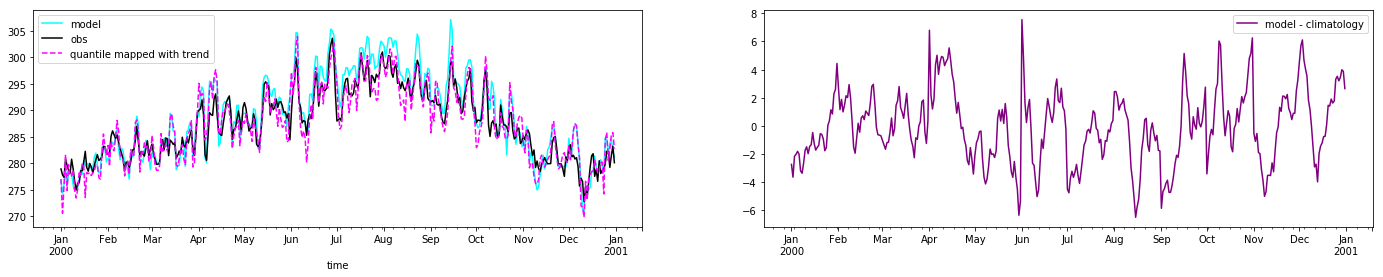

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(24, 4))
# X_rolling_mean['T2max'][(X_rolling_mean.index >= '2000') & (X_rolling_mean.index < '2001')].plot(ax=axes[0], label='rolling mean of model', color='red')
X_daily_slice['T2max'][(X_daily_slice.index >= '2000') & (X_daily_slice.index < '2001')].plot(ax=axes[0], label='model', color='cyan')
y_daily['Tmax'][(y_daily.index >= '2000') & (y_daily.index < '2001')].plot(ax=axes[0], label='obs', color='black')
# X_no_shift['T2max'][(X_no_shift.index >= '2000') & (X_no_shift.index < '2001')].plot(ax=axes[0], label='model - rolling mean trend', color='pink', linestyle='dashed')

# Xqm['T2max'][(Xqm.index >= '2000') & (Xqm.index < '2001')].plot(ax=axes[0], label='quantile mapped', color='navy', linestyle='dotted')

# X_qm_with_shift
(X_shift['T2max'][(X_shift.index >= '2000') & (X_shift.index < '2001')] + 
                   Xqm['T2max'][(Xqm.index >= '2000') & (Xqm.index < '2001')]).plot(ax=axes[0], 
                   label='quantile mapped with trend', color='magenta', linestyle='dashed')
axes[0].legend()

X_shift['T2max'][(X_shift.index >= '2000') & (X_shift.index < '2001')].plot(ax=axes[1], label='model - climatology', color='purple')

axes[1].legend()

In [ ]:
X_bc_anoms.head()

In [ ]:
y_daily.head()

In [64]:
# X_daily_predicted = X_bc_anoms['T2max'] + y_daily['Tmax']
X_daily_predicted = X_bc_anoms['T2max'] + y_daily['Tmax']

Text(0,0.5,'Temperature (K)')

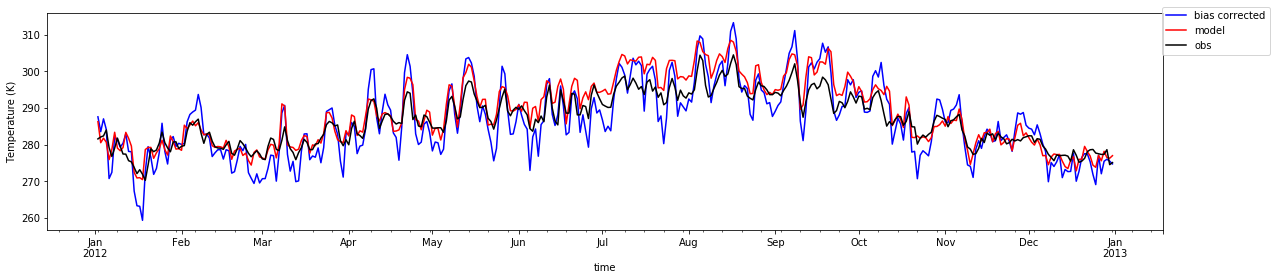

In [65]:
fig, axes = plt.subplots(1, 1, figsize=(20, 4))

start_year = '2012'
end_year = '2013'

mask_predicted = (X_daily_predicted.index > start_year) & (X_daily_predicted.index < end_year)
mask_X = (X_daily_slice.index > start_year) & (X_daily_slice.index < end_year)
mask_y = (y_daily.index > start_year) & (y_daily.index < end_year)

# X_daily_predicted[mask_predicted].plot(label='bias corrected', color='blue', ax=axes)
X_daily_predicted[mask_predicted].plot(label='bias corrected', color='blue', ax=axes)
X_daily_slice[mask_X]['T2max'].plot(label='model', color='red', ax=axes)
y_daily[mask_y]['Tmax'].plot(label='obs', color='black', ax=axes)
axes.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
axes.set_ylabel('Temperature (K)')

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 4))

X_daily_predicted.plot(label='bias corrected', color='blue', ax=axes)
X_daily_slice['T2max'].plot(label='model', color='red')
y_daily['Tmax'].plot(label='obs', color='black', ax=axes)
axes.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
axes.set_ylabel('Temperature (K)')

In [ ]:
X_daily_slice

In [ ]:
plot_cdf(X=X_temp, y=y_temp, out=out)
out.plot()